**AIRLINE TWEETS SENTIMENT ANALYSIS USING ULMFIT.**

The data was taken from Kaggle . The problem statement here is to predict the sentiment of a tweet. Tweets in the training set are labelled as negative, positive or neutral. 
I am using ULMFIT's AWD-LSTM architecture to predict the sentiment. Fastai has made their libraries open sourced and hence I used the fastapi's interface for prediction. This makes is extremely easy. 


**Feature Engineering**.

This involves some basic steps to clean up the tweet text, so as to make it easier for interpretation. 
I removed the Unicode characters, replaced URL, remove Numbers , removed the @ which indicates the user, because that part plays no role in the sentiment analysis and also removed Emoticons. I also converted the labels negative positive and neutral to integers - 0,2 and 1 respectively. 


The approach used in this is based on ULMFIT's paper  on transfer learning for NLP. 
ULMFIT was designed to implement transfer learning similar to what we see in computer vision models,where they are not trained from scratch, instead they are pretrained on basic image datasets like ImageNET, and then are trained on the particular dataset you are working on to tune it and make it understand the nuances in your dataset. ULMFIT tries to do the same thing for NLP and beats the performance of existing appproaches. 
The ULMFIT approach involves the following steps:


1.   Developing a language model. The WIKI103 dataset is  used to train the neural network and understand the language model. The WIKI103 contains about a million words. We use this as sort of an encoder , to understand representations in the english language.This is called **GENERAL DOMAIN LANGUAGE MODELLING**.
2.   Target task Language model fine tuning - In this step, we tune the language model we built in step 1 to the target task dataset, which is the airline tweets dataset , on the text it contains and the labels.  Then we use the tuning techniques described in the paper.
3. Target task classifier fine tuning - we create the classifier for predicting the sentiment in this step and use tuning approaches described in the paper to fine tune the classifier using discriminative fine tuning and gradual unfreezing of layers. This technique will be explained later on in the notebook, when it is actually performed. 







In [ ]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import pandas_profiling
from nltk import WordPunctTokenizer
from nltk import WordNetLemmatizer
from sklearn.metrics import accuracy_score
from fastai import *
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
stop_words = stopwords.words("english")
nltk.download("wordnet")
from fastai.text.data import TextLMDataBunch
from fastai.text.data import TextClasDataBunch
from fastai.text.learner import language_model_learner
from fastai.text.models import AWD_LSTM
from fastai.text.learner import text_classifier_learner
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
PATH = "/"
PRE_PATH = PATH+"/models/wt103"
PRE_LM_PATH = PRE_PATH+ "/fwd_wt103.h5"
DATA_PATH = "/content/gdrive/My Drive/Tweets.csv"

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
stop_words.remove("by")

In [ ]:
class Data():


  def __init__(self,data_path):
    self.train = []
    self.test = []
    self.augment_train = []
    self.augment_test = []
    self.data =self._read_data(data_path)
    self.tweets = self._preprocess_tweets(self.data.copy()) 
    self._create_train_test(self.tweets)
    

  def _read_data(self, data_path):
    return pd.read_csv(data_path)

  def piechart(self,df,column):
    return px.pie(df,names = column)
    

  def count_plot(self,df,column,hue):
    plt.figure(figsize=(12,7))
    sns.set(style="ticks" , color_codes=True)
   # sns.countplot(x = tweets["airline"] , hue = tweets["airline_sentiment"])#,palette=)
    return sns.countplot(x = df[column] , hue = df[hue])#,palette=)

 


  def _removeUnicode(self,text):
    """ Removes unicode strings like "\u002c" and "x96" """
    text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)       
    text = re.sub(r'[^\x00-\x7f]',r'',text)
    return text

  def _replaceURL(self,text):
      """ Replaces url address with "url" """
      
      text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',text)
      text = re.sub(r'#([^\s]+)', r'\1', text)
      return text

  def _replaceAtUser(self,text):
      """ Replaces "@user" with "atUser" """
      
      text = re.sub('@[^\s]+','',text)
      return text

  def _removeHashtagInFrontOfWord(self,text):
      """ Removes hastag in front of a word """
      text = re.sub(r'#([^\s]+)', r'\1', text)
      return text

  def _removeNumbers(self,text):
      """ Removes integers """
      text = ''.join([i for i in text if not i.isdigit()])         
      return text

  def _removeEmoticons(self,text):
      """ Removes emoticons from text """
      text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', '', text)
      return text

  def _lemmatized(self,text):
    """
    Tokenizing and lemmatization of text
    """
    tokenizer = WordPunctTokenizer()
    lemmatizer = WordNetLemmatizer()
    tokens = tokenizer.tokenize(text)
    final =[lemmatizer.lemmatize(token)  for token in tokens if token not in stop_words ]
    
    return " ".join(final)
    

  def _replace_sentiment(self,sentiment):
    """
    Replace sentiment string with integers. 
    """
    sent_dict = {"negative":0 , "positive":2, "neutral":1 }
    return sent_dict[sentiment]

  def _map_values(self,num):
    sentiment = { 0:"negative" ,4 : "positive" }
    return sentiment[num]

  
  def plot_word_cloud(self,sentiment):
    stop = stop_words.extend(["Thanks","Thank","plane","airplane"])
    df = self.tweets[self.tweets["sentiment"]== sentiment]
    wc_text=",".join(list(df["text"].values))
    wordcloud = WordCloud(stopwords=stop, background_color="white",max_words=50).generate(wc_text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.figure(figsize=(20,7))
    plt.axis("off")
    plt.show()

  
  

  def _preprocess_tweets(self,df):
    '''
     perform preprocessing using above methods. 

    '''
    
    df = df.rename(columns = {"airline_sentiment":'sentiment'})
    #call augmenting function here and then pass on to the rest

    df = df[['sentiment',"text"]]
    df["text"] = df["text"].apply(self._removeUnicode)
    df["text"] = df["text"].apply(self._replaceURL)
    df["text"] = df["text"].apply(self._replaceAtUser)
    df["text"] = df["text"].apply(self._removeHashtagInFrontOfWord)
    df["text"] = df["text"].apply(self._removeEmoticons)
    df["text"] = df["text"].apply(self._removeNumbers)
    df["text"] = df["text"].apply(self._lemmatized)
    df['sentiment'] = df['sentiment'].apply(self._replace_sentiment)
    return df


  def _create_train_test(self,df):
    self.test = df.sample(frac = 0.20)
    self.train = df.drop(self.test.index)


  def augmented(self):
    augment = pd.read_csv("/content/gdrive/My Drive/twitter_aug.csv",header=None,encoding = "latin-1")
    augment.columns =["sentiment","ids","date","flag","user","text"]
    augment.drop(["ids","date","flag","user"] ,  axis =1 , inplace=True)
    augment["sentiment"] = augment["sentiment"].apply(self._map_values)
    augment["text"] = augment["text"].apply(self._removeUnicode)
    augment["text"] = augment["text"].apply(self._replaceAtUser)
    augment["text"] = augment["text"].apply(self._removeHashtagInFrontOfWord)
    augment["text"] = augment["text"].apply(self._removeNumbers)
    augment["text"] = augment["text"].apply(self._replaceURL)
    augment["text"] = augment["text"].apply(self._lemmatized)
    augment['sentiment'] = augment['sentiment'].apply(self._replace_sentiment)
    augment = augment[augment['sentiment']==2]
    print(len(augment))
    train_copy = train.copy()
    
    
    train_copy = train_copy.append(augment,ignore_index = True )
    self.augment_test= train_copy.sample(frac = 0.2)
    self.augment_train = train_copy.drop(self.augment_test.index)



    
 


    
    


In [ ]:
class Model():

  def __init__(self,train,test,drop_mult=0.4,arch =AWD_LSTM ,pretrained = True ):

    self.data_lm = TextLMDataBunch.from_df(train_df = train, valid_df = test, 
                                           path = "")
    self.data_clas = TextClasDataBunch.from_df(path = "", train_df = train, valid_df = test, 
                                      vocab = self.data_lm.train_ds.vocab, bs=32)
    self.learn = language_model_learner(self.data_lm, arch=arch, pretrained = True,
                                        drop_mult = drop_mult)
    self.learn_classifier = text_classifier_learner(self.data_clas, arch = arch,
                                                    drop_mult = drop_mult)
    


  def train_lm(self,learning_rate,encoder_name):
    """
    train language model and fine tune it using discriminative fine tuning technique mentioned in paper. 
    """
    #fit the learn and train it 
    self.learn.lr_find()
    self.learn.recorder.plot()
    self.learn.fit_one_cycle(1, learning_rate)
                              #1e-2)
    learning_rate = learning_rate/2.6
    self.learn.freeze_to(-1)#freeze all layers except this one. Train this layer with a particular learning rate. 
    self.learn.fit_one_cycle(1,learning_rate)
    #self.learn.fit_one_cycle(1,1e-2)
    learning_rate = learning_rate/2.6
    self.learn.freeze_to(-2)
    self.learn.fit_one_cycle(1,learning_rate)
    learning_rate = learning_rate/2.6
    self.learn.freeze_to(-3)
    self.learn.fit_one_cycle(1 , learning_rate)
    self.learn.unfreeze()
    self.learn.fit_one_cycle(1, 1e-2)
    self.learn.save_encoder(encoder_name)




  def train_learn_classifier(self,encoder_name):
    """
      Training the classifier on the task data, and finally using it to make a prediction . 
    """
    self.learn_classifier = text_classifier_learner(self.data_clas,arch = AWD_LSTM,drop_mult=0.5)
    self.learn_classifier.load_encoder(encoder_name)
    self.learn_classifier.fit_one_cycle(1,1e-2)
    self.learn_classifier.freeze_to(-1)
    self.learn_classifier.fit_one_cycle(1, slice(5e-3/2., 5e-3))
    self.learn_classifier.freeze_to(-2)
    self.learn_classifier.fit_one_cycle(1, slice(1e-4,1e-1), moms=(0.8,0.7))
    self.learn_classifier.freeze_to(-3)
    self.learn_classifier.fit_one_cycle(1, slice(1e-04,5e-3), moms=(0.8,0.7))
    self.learn_classifier.unfreeze()
    self.learn_classifier.fit_one_cycle(5, slice(1e-04,5e-3), moms=(0.8,0.7))
    

    
    
  def predict(self):
      preds, targets = self.learn_classifier.get_preds()
      predictions = np.argmax(preds, axis=1)
      print(classification_report(targets, predictions))
      return preds,targets
      

  def predict_sentiment(self,text):
      pred = self.learn_classifier.predict(text)
      return pred

        








In [ ]:
df = Data(DATA_PATH)
tweets = df.data
tweets.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

**EXPLORATORY DATA ANALYSIS**

As seen, we don't see any missing values for text, Which is good for us. 

In [ ]:
negative = tweets[tweets["airline_sentiment"]=="negative"]


In [ ]:
negative.isnull().sum()

tweet_id                           0
airline_sentiment                  0
airline_sentiment_confidence       0
negativereason                     0
negativereason_confidence          0
airline                            0
airline_sentiment_gold          9146
name                               0
negativereason_gold             9146
retweet_count                      0
text                               0
tweet_coord                     8515
tweet_created                      0
tweet_location                  3142
user_timezone                   3170
dtype: int64

The null values for negative reason in the original dataframe can be explained, only where the tweets are negative it contains the negative reason. 

In [ ]:
df.piechart(negative,"negativereason")

As seen from above piechart, The most popular reason for negative sentiment has been  Customer Service issue , followed by Late Flight, Cancelled flight.

In [ ]:
united = negative[negative["airline"] == "United"]

In [ ]:
df.piechart(united,"negativereason")

For the airline with the highest number of negative tweets, the top four reasons appear to be Customer service issue, Late flights, Can't tell(must not be anything specific) followed by Lost luggage. A good 10.2 percent of the negative tweets had Lost bagge as reason. 1 in 10 bags get's misplaced.

In [ ]:
#you can generate word cloud for positive tweets. 

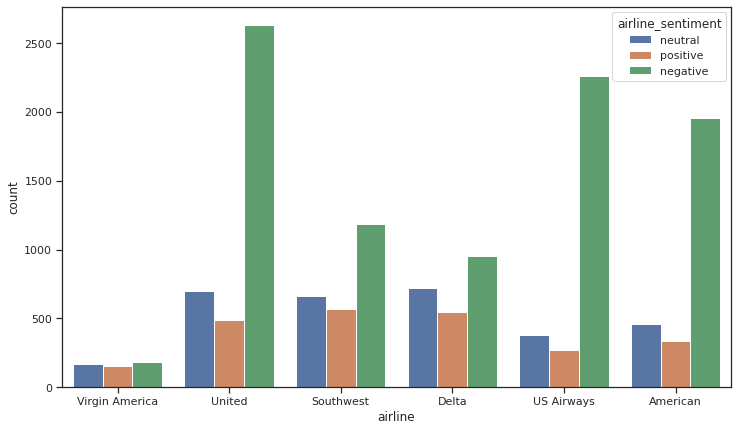

In [ ]:
df.count_plot(tweets,"airline","airline_sentiment")

As you can see, the number of negative tweets present are much much higher than the other two categories of sentiment(positive and negative)

In [ ]:
df.piechart(tweets,"airline_sentiment")

WORDCLOUD FOR THE TOP MOST WORDS FOUND IN POSITIVE REVIEWS.

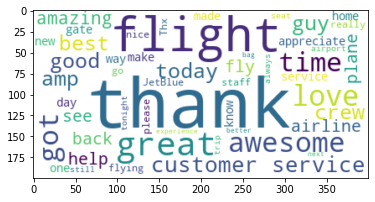

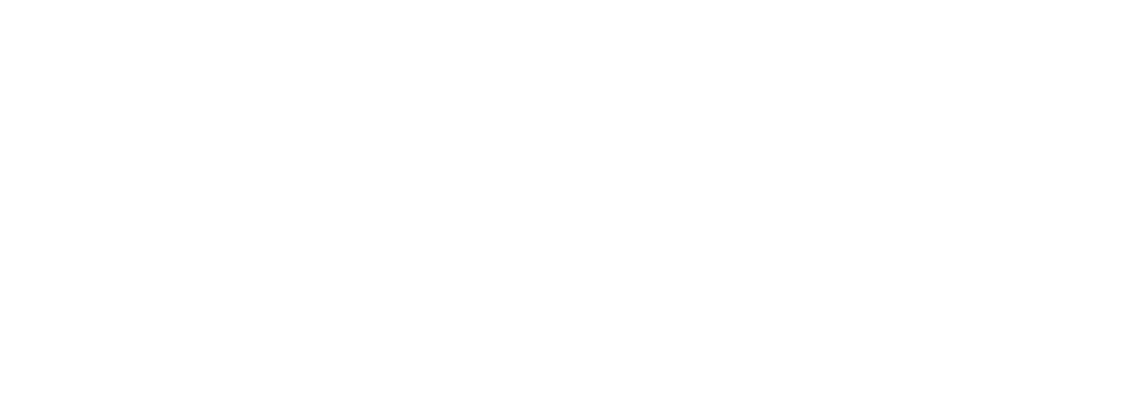

In [ ]:
df.plot_word_cloud(2)

As seen from the cloud, the most common words for the positive tweets were customer service, amazing ,awesome, help,love

For negative reviews

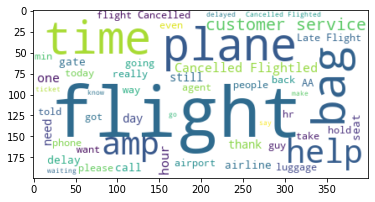

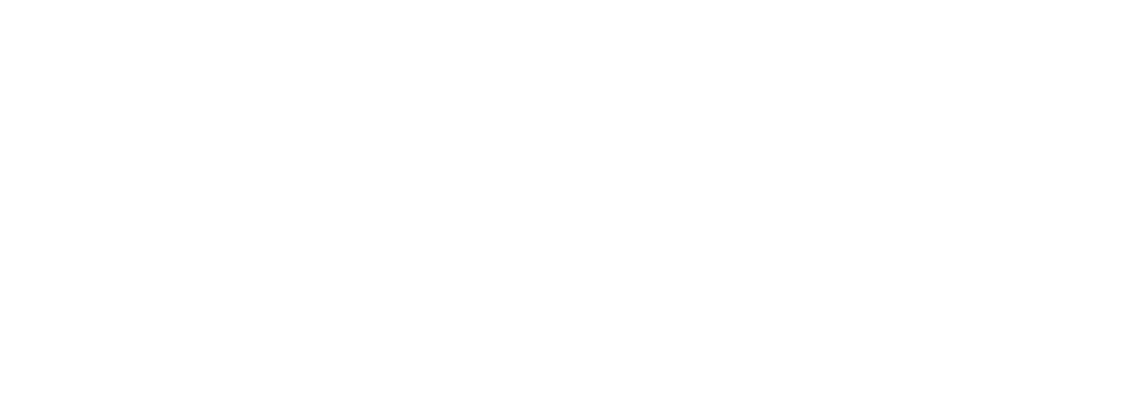

In [ ]:
df.plot_word_cloud(0)

62.7 % tweets are negative, and 16.1% tweets are positive, and 21.2% tweets are neutral.

In [ ]:
train, test = df.train, df.test
model = Model(train, test)

In this phase, the language model is trained on the wikitext corpus and tuned using Discriminative tuning

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time
0,5.780013,4.999954,0.182670,00:15


epoch,train_loss,valid_loss,accuracy,time
0,5.019638,4.820484,0.201928,00:15


epoch,train_loss,valid_loss,accuracy,time
0,4.784175,4.660367,0.221165,00:15


epoch,train_loss,valid_loss,accuracy,time
0,4.625724,4.581782,0.229870,00:17


epoch,train_loss,valid_loss,accuracy,time
0,4.652691,4.468292,0.243263,00:19


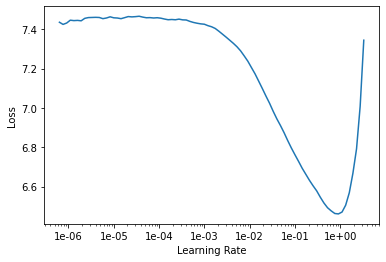

In [ ]:
model.train_lm(1e-2,"language_model")

Now we tune the classifier model, which is fit on the task at hand, the tweets , and tune the classifier using discriminative tuning. 

In [ ]:
model.train_learn_classifier("language_model")

epoch,train_loss,valid_loss,accuracy,time
0,0.655926,0.589171,0.764003,00:15


epoch,train_loss,valid_loss,accuracy,time
0,0.631793,0.569137,0.762978,00:15


epoch,train_loss,valid_loss,accuracy,time
0,0.648711,0.546634,0.781762,00:17


epoch,train_loss,valid_loss,accuracy,time
0,0.546080,0.514446,0.799863,00:26


epoch,train_loss,valid_loss,accuracy,time
0,0.535821,0.504322,0.804303,00:34
1,0.508707,0.502799,0.803279,00:34
2,0.410599,0.533903,0.803962,00:34
3,0.297732,0.593837,0.797131,00:34
4,0.201328,0.619607,0.803620,00:34


In [ ]:
preds,target = model.predict()

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1832
           1       0.66      0.60      0.63       617
           2       0.76      0.71      0.73       479

    accuracy                           0.80      2928
   macro avg       0.76      0.73      0.74      2928
weighted avg       0.80      0.80      0.80      2928



I used the standard metrics for sentiment analysis - accuracy, precision , recall and f1 score. Simply accuracy is not a good indicator of the performance

The overall accuracy of the model is 80 percent. This is on par with all the other attempts on sentiment Analysis using ULMFIT. Based on the results above, it is able to identify negative tweets very well, as compared to the the other two categories. The f1 score is 88%, amd precision is 0.85, which means of all the tweets we classified as negative, 86% of them were actually negative. It has a high recall score , that is it was able to correclty classifiy 91 percent of negative tweets as negative. The recall is low for neutral( the original dataset, they had very few neutral tweets, and I think this has affected it's judgement. It had very little data to identify the different ways a neutral tweet could be written. I think this performance can be fixed by adding some neutral annotated tweets. We could use data augmentation to improve it's performance. For both positive and neutral tweets.


